In [1]:
import os; os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "garbage_collection_threshold:0.5"
import io, time, torch, datasets, PIL.Image, numpy as np, matplotlib.pyplot as plt, fastprogress, IPython.display, pillow_jpls
from einops.layers.torch import Rearrange
from types import SimpleNamespace
from typing import OrderedDict
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image
from torchvision.transforms import Compose, Resize, RandomCrop, CenterCrop, ColorJitter
from attend.asym import ConvND, ConvTransposeND, AsymptoticSphereNorm, GELUTanh, Quantize, VitBlockND
from timm.optim import Adan
from livecodec.codec import latent_to_pil, pil_to_latent
from huggingface_hub import hf_hub_download

In [2]:
device = 'cuda:1'
dataset = datasets.DatasetDict({
    'train': datasets.load_dataset("danjacobellis/LSDIR",split='train'),
    'validation': datasets.load_dataset("danjacobellis/kodak",split='validation')
})

path = hf_hub_download(
    repo_id='danjacobellis/storage',
    filename='v3_p16_c48.pth',
)

checkpoint = torch.load(path,weights_only=False)
config = checkpoint['config']

# config = SimpleNamespace()
# config.input_dim = 2
# config.input_channels = 3
# config.ps = 16
# config.dr = 16
# config.use_wpt = False
# config.latent_dim = int(config.input_channels*(config.ps**config.input_dim)/config.dr)
# config.decoder_depth = 16
# config.hidden_dim = 768
# config.λ = 3e-2
config.epochs = 20
config.batch_size = 4
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.min_aspect = 0.625
config.max_aspect = 1.75
config.min_size = 512
config.max_size = 768
config.min_scale = 1.0
config.max_scale = 1.0
config.max_lr = 3e-4
config.min_lr = 1e-8
config.lr_pow = 2
config.num_workers = 12
config.save_checkpoint_name = f'checkpoint_{device}.pth'

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [3]:
class V3(torch.nn.Module):
    def __init__(self, dim, ch, ps, latent_dim, hidden_dim, decoder_depth, use_wpt):
        super().__init__()
        self.dim = dim
        self.ch = ch
        self.ps = ps
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.decoder_depth = decoder_depth
        self.J = int(np.log2(ps))
        self.patch_dim = ch*(ps**dim)
        stride = 1 if use_wpt else ps
        if dim == 1:
            from tft.wavelet import WPT1D, IWPT1D, DWT1DForward, DWT1DInverse
            self.wt = DWT1DForward(J=1, wave='bior4.4')
            self.wpt = WPT1D(wt=self.wt, J=self.J)
            self.iwt = DWT1DInverse(wave='bior4.4')
            self.iwpt = IWPT1D(iwt=self.iwt, J=self.J)
            conv_layer = torch.nn.Conv1d
        elif dim == 2:
            from tft.wavelet import WPT2D, IWPT2D, DWT2DForward, DWT2DInverse
            self.wt = DWT2DForward(J=1, wave='bior4.4')
            self.wpt = WPT2D(wt=self.wt, J=self.J)
            self.iwt = DWT2DInverse(wave='bior4.4')
            self.iwpt = IWPT2D(iwt=self.iwt, J=self.J)
            conv_layer = torch.nn.Conv2d
        elif dim == 3:
            from tft.wavelet import WPT3D, IWPT3D, DWT3DForward, DWT3DInverse
            self.wt = DWT3DForward(J=1, wave='bior4.4')
            self.wpt = WPT3D(wt=self.wt, J=self.J)
            self.iwt = DWT3DInverse(wave='bior4.4')
            self.iwpt = IWPT3D(iwt=self.iwt, J=self.J)
            conv_layer = torch.nn.Conv3d
        self.layers = torch.nn.Sequential(
            OrderedDict(
                [
                    ("analysis_transform", torch.nn.Sequential(
                        OrderedDict(
                            [
                                ("wpt", self.wpt if use_wpt else torch.nn.Identity()),
                                ("norm", AsymptoticSphereNorm() if use_wpt else torch.nn.Identity()),
                                ("act", torch.nn.Identity()),
                                ("nn", ConvND(self.dim, self.patch_dim if use_wpt else ch, self.latent_dim, kernel_size=stride, stride=stride, padding=0)),
                            ]
                        )
                    )),
                    ("norm", AsymptoticSphereNorm()),
                    ("quantize", Quantize()),
                    ("synthesis_transform", torch.nn.Sequential(
                        OrderedDict(
                            [
                                ("nn", torch.nn.Sequential(
                                    ConvND(self.dim, self.latent_dim, config.hidden_dim, kernel_size=1, stride=1, padding=0),
                                    *[VitBlockND(dim, in_channels=config.hidden_dim, norm_layer=AsymptoticSphereNorm, act_layer=GELUTanh, quant_layer=torch.nn.Identity, head_dim=32, expand_ratio=2, drop_path=0.0)
                                      for _ in range(config.decoder_depth)],
                                    ConvTransposeND(self.dim, self.hidden_dim, self.patch_dim if use_wpt else ch, kernel_size=stride, stride=stride, padding=0),
                                )),
                                ("iwpt", self.iwpt if use_wpt else torch.nn.Identity()),
                            ]
                        )
                    )),
                ]
            )
        )
    def forward(self, x):
        return self.layers(x)
        
    def forward_rate(self, x):
        z = self.layers[:3](x)
        rate = z.std().log2()
        xhat = self.layers[-1](z)
        return xhat, rate

    def forward_hard_quant(self, x):
        with torch.no_grad():
            z = self.layers[:2](x).round()
        xhat = self.layers[-1](z)
        return xhat

In [4]:
model = V3(dim=2, ch=config.input_channels, ps=config.ps, latent_dim=config.latent_dim, hidden_dim=config.hidden_dim, decoder_depth=config.decoder_depth, use_wpt = config.use_wpt)
model = model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6)

model.load_state_dict(checkpoint['state_dict'])
model.layers.analysis_transform.requires_grad_(False)
model.layers.norm.requires_grad_(False)
trainable_params = [p for p in model.parameters() if p.requires_grad]
print(sum(p.numel() for p in trainable_params)/1e6)

optimizer = Adan(trainable_params, lr=1.0)
def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr
schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

76.481331
76.444419


In [5]:
def train_collate_fn(batch):
    aspect = np.random.uniform(config.min_aspect,config.max_aspect)
    h = np.random.uniform(config.min_size,config.max_size); w = h*aspect;
    h = int((config.ps*(np.rint(h/config.ps))).clip(config.min_size,config.max_size))
    w = int((config.ps*(np.rint(w/config.ps))).clip(config.min_size,config.max_size))
    x = []
    for i_sample, sample in enumerate(batch):
        transform = Compose([
            Resize(
                int(max(h,w)*np.random.uniform(config.min_scale,config.max_scale)),
                interpolation=PIL.Image.Resampling.BICUBIC,
                max_size=1+int(config.max_scale*config.max_size)
            ),
            RandomCrop((h,w),pad_if_needed=True,padding_mode='symmetric'),
            ColorJitter(0.4,0.0,0.4,0.0),
        ])
        xi = pil_to_tensor(transform(sample['image'].convert("RGB"))).unsqueeze(0)
        x.append(xi)
    x = torch.cat(x)
    return x.to(torch.float)/127.5 - 1.0

def enc_dec(sample):
    img = sample['image']
    buff = io.BytesIO()
    x = pil_to_tensor(img).to(torch.float).to(device).unsqueeze(0)/127.5 - 1.0
    t0 = time.time()
    with torch.inference_mode():
        z = model.layers[0:2](x).round()
    latent_to_pil(z.cpu().detach(),n_bits=8,C=3)[0].save(buff, format='JPEG-LS')
    enc_time = time.time() - t0
    size_bytes = len(buff.getbuffer())
    t0 = time.time()
    z = pil_to_latent([PIL.Image.open(buff)],N=config.latent_dim,n_bits=8,C=3).to(device)
    with torch.inference_mode():
        xhat = model.layers[-1](z).clamp(-1,1)
    dec_time = time.time() - t0
    x_01 = x/2 + 0.5
    xhat_01 = xhat/2 + 0.5
    psnr = -10*torch.nn.functional.mse_loss(x_01, xhat_01).log10().item()
    del sample['path']
    del sample['image']
    return{
        'psnr': psnr,
        'cr': x.numel()/size_bytes,
        'enc': (x.numel()/3e6)/enc_time,
        'dec': (x.numel()/3e6)/dec_time
    }

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = fastprogress.master_bar(range(config.epochs))
log_mse_losses = []
# rate_losses = []
valid_metrics = []
global_step = 0
for i_epoch in mb:
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=train_collate_fn
        )
    pb = fastprogress.progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device);
        # xhat,rate = model.forward_rate(x)
        xhat = model.forward_hard_quant(x)
        log_mse_loss = torch.nn.functional.mse_loss(x,xhat).log10()
        log_mse_losses.append(log_mse_loss.item())
        # rate_losses.append(rate.item())
        # total_loss = log_mse_loss + config.λ * rate
        total_loss = log_mse_loss
        optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0, norm_type=2.0)
        optimizer.step()
        schedule.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"log mse: {log_mse_losses[-1]:.3g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    model.eval()
    valid = dataset['validation'].map(enc_dec)
    valid_metrics.append({key: torch.tensor(valid[key]).mean().item() for key in valid.features.keys()})
    mb.main_bar.comment = ";  ".join([f'{key}: {valid_metrics[-1][key]:0.4g}' for key in valid_metrics[-1]])
    
    torch.save({
        'i_epoch': i_epoch,
        'log_mse_losses': log_mse_losses,
        # 'rate_losses': rate_losses,
        'learning_rates': learning_rates,
        'valid_metrics': {k: [d[k] for d in valid_metrics] for k in valid_metrics[0].keys()},
        'config': config,
        'state_dict': model.state_dict()
    }, config.save_checkpoint_name)

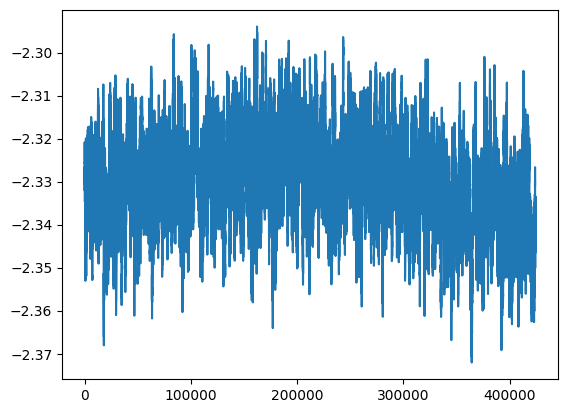

In [9]:
display(IPython.display.HTML(mb.main_bar.progress))
display(IPython.display.HTML(pb.progress))
N = 501; plt.plot(np.convolve(log_mse_losses, N*[1/N], mode='valid'))

In [10]:
torch.tensor(([[v[key] for key in v.keys()] for v in valid_metrics]))[-1]

tensor([ 31.1820,  37.3420, 191.0480,  45.7370])

In [11]:
torch.save({
    'i_epoch': i_epoch,
    'log_mse_losses': log_mse_losses,
    # 'rate_losses': rate_losses,
    'learning_rates': learning_rates,
    'valid_metrics': {k: [d[k] for d in valid_metrics] for k in valid_metrics[0].keys()},
    'config': config,
    'state_dict': model.state_dict()
}, 'v3_p16_c48_ft.pth')

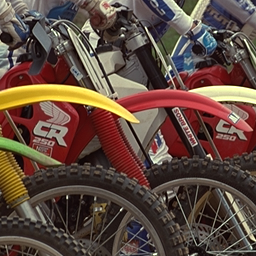

cr: 26.130781499202552
psnr: 26.028133392333984


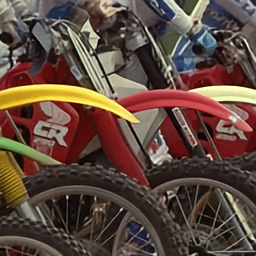

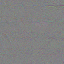

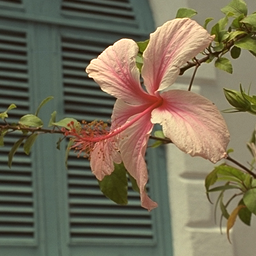

cr: 29.42352589045196
psnr: 31.207401275634766


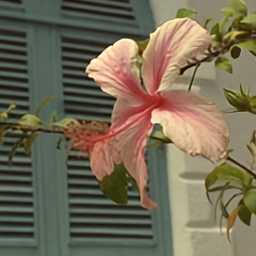

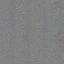

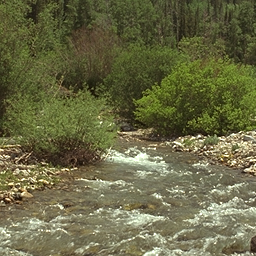

cr: 29.73502722323049
psnr: 23.666606903076172


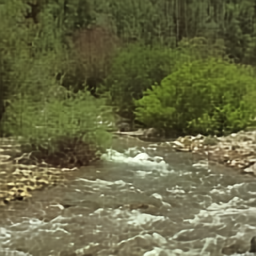

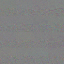

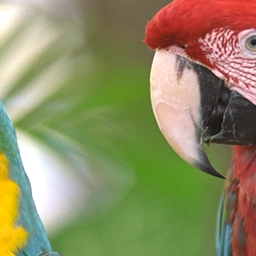

cr: 35.48880866425993
psnr: 33.94221878051758


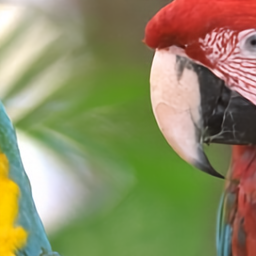

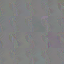

In [12]:
model.eval()
for sample in dataset['validation'].select([4,6,12,22]):
    img = CenterCrop(256)(sample['image'])
    x = pil_to_tensor(img).to(torch.float).to(device).unsqueeze(0)/127.5 - 1.0
    with torch.inference_mode():
        z = model.layers[0:2](x).round()
        buff = io.BytesIO()
        latent_to_pil(z.cpu().detach(),n_bits=8,C=3)[0].save(buff, format='JPEG-LS')
        size_bytes = len(buff.getbuffer())
        xhat = model.layers[-1](z).clamp(-1,1)
        psnr = -10*torch.nn.functional.mse_loss(x/2,xhat/2).log10()
    display(img)
    print(f'cr: {x.numel()/size_bytes}\npsnr: {psnr.item()}')
    display(to_pil_image(xhat[0]/2 + 0.5))
    display(PIL.Image.open(buff))

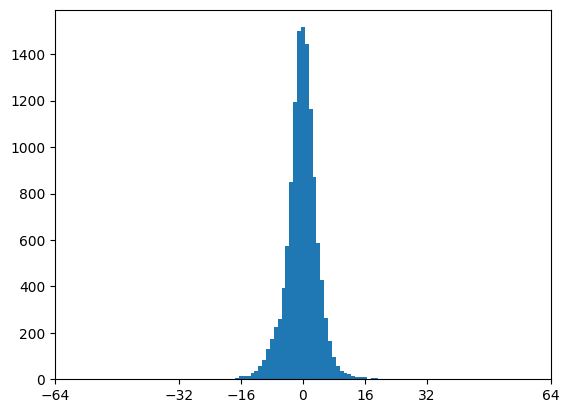

In [13]:
plt.hist(z.cpu().flatten(),range=(-127.5,127.5),bins=255);
plt.xlim([-64,64]);
plt.xticks([-64,-32,-16,0,16,32,64]);

In [ ]:
model.eval()
for sample in dataset['validation'].select([4,6,12,22]):
    img = sample['image']
    x = pil_to_tensor(img).to(torch.float).to(device).unsqueeze(0)/127.5 - 1.0
    with torch.inference_mode():
        z = model.layers[0:2](x).round()
        buff = io.BytesIO()
        latent_to_pil(z.cpu().detach(),n_bits=8,C=3)[0].save(buff, format='JPEG-LS')
        size_bytes = len(buff.getbuffer())
        xhat = model.layers[-1](z).clamp(-1,1)
        psnr = -10*torch.nn.functional.mse_loss(x/2,xhat/2).log10()
    display(img)
    print(f'cr: {x.numel()/size_bytes}\npsnr: {psnr.item()}')
    display(to_pil_image(xhat[0]/2 + 0.5))
    display(PIL.Image.open(buff))

In [ ]:
plt.hist(z.cpu().flatten(),range=(-127.5,127.5),bins=255);
plt.xlim([-64,64]);
plt.xticks([-64,-32,-16,0,16,32,64]);